# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths for data splits and output.  
- Detect GPU/CPU.

<a id="step2"></a>
## Step 2: Model Definition
Defines:
- `GAT`: stacks layers, global mean pool, and final linear head.

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_dim`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Imports and Setup

In [71]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.nn import GATConv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [ ]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

task = "classification"  # or "regression"
#task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GAT_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define GAT Model

In [73]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin = Linear(hidden_channels * heads, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        return self.lin(x)

# class GAT(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout, edge_dim):
#         super().__init__()
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout, edge_dim=edge_dim)
#         self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout, edge_dim=edge_dim)
#         self.lin = Linear(hidden_channels * heads, out_channels)

#     def forward(self, data):
#         # 从 data 对象中获取所需的所有属性
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

#         x = self.conv1(x, edge_index, edge_attr).relu()  # 注意这里传入 edge_attr
#         x = self.conv2(x, edge_index, edge_attr).relu()  # 这里也传入 edge_attr
        
#         x = global_mean_pool(x, batch)
        
#         return x
    

## 4. Evaluation Helper Function

In [74]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [75]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/1340473836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(os.path.join(base_pa

# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [76]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

hidden_channels = [64, 128, 256]
dropouts    = [0.0, 0.2, 0.4]
lrs         = [1e-3, 5e-4, 1e-4]

# hidden_channels = [64]
# dropouts    = [0.4]
# lrs         = [1e-3]

results = []

for hd in hidden_channels:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            auc_scores = []
            bal_scores = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
                
                model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=hd,
                            out_channels=num_classes, heads=1, dropout=dp).to(device)
                        # GAT(train_data[0].x.size(1),
                        #      train_data[0].edge_attr.size(1),
                        #      output_dim=num_classes,
                        #      dropout=dp).to(device)
                opt = torch.optim.Adam(model.parameters(), lr=lr)
                tr = DataLoader(train_data, batch_size=32, shuffle=True,
                                worker_init_fn=seed_worker, generator=generator)
                vl = DataLoader(val_data,   batch_size=32)

                # Train
                for epoch in range(1, 51):
                    model.train()
                    for batch in tr:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = F.cross_entropy(out, batch.y.long())
                        loss.backward()
                        opt.step()

                # Eval
                preds, labels = evaluate(model, vl)
                y_true = labels.numpy().astype(int)
                y_probs = F.softmax(preds, dim=1).numpy()
                y_pred  = preds.argmax(dim=1).numpy()

                # AUC‑ROC (one-vs-rest)
                auc = roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs, multi_class='ovr'
                )
                auc_scores.append(auc)

                # Balanced Accuracy
                bal = balanced_accuracy_score(y_true, y_pred)
                bal_scores.append(bal)

            # Record mean±std for both metrics
            results.append({
                "hidden_dim": hd,
                "dropout":    dp,
                "lr":         lr,
                "mean_auc":   np.mean(auc_scores),
                "std_auc":    np.std(auc_scores),
                "mean_balanced_acc": np.mean(bal_scores),
                "std_balanced_acc":  np.std(bal_scores),
            })

            print(f"📊 AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f} | "
                  f"Balanced Acc: {np.mean(bal_scores):.4f} ± {np.std(bal_scores):.4f}")

# Build DataFrame and sort by mean balanced accuracy (or mean_auc)
sweep_df = pd.DataFrame(results)
display(sweep_df.sort_values("mean_balanced_acc", ascending=False))
# Save the results
sweep_df.to_csv(os.path.join(results_dir, "sweep_results.csv"), index=False)



🔧 Config: hidden_dim=64, dropout=0.0, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7345 ± 0.0464 | Balanced Acc: 0.4889 ± 0.0278

🔧 Config: hidden_dim=64, dropout=0.0, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7349 ± 0.0556 | Balanced Acc: 0.4908 ± 0.0363

🔧 Config: hidden_dim=64, dropout=0.0, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7042 ± 0.0622 | Balanced Acc: 0.3434 ± 0.0348

🔧 Config: hidden_dim=64, dropout=0.2, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7445 ± 0.0545 | Balanced Acc: 0.5003 ± 0.0377

🔧 Config: hidden_dim=64, dropout=0.2, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7283 ± 0.0523 | Balanced Acc: 0.4828 ± 0.0378

🔧 Config: hidden_dim=64, dropout=0.2, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7138 ± 0.0651 | Balanced Acc: 0.3536 ± 0.0421

🔧 Config: hidden_dim=64, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7378 ± 0.0509 | Balanced Acc: 0.4827 ± 0.0387

🔧 Config: hidden_dim=64, dropout=0.4, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7284 ± 0.0542 | Balanced Acc: 0.5003 ± 0.0216

🔧 Config: hidden_dim=64, dropout=0.4, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.6869 ± 0.0817 | Balanced Acc: 0.3620 ± 0.0560

🔧 Config: hidden_dim=128, dropout=0.0, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7428 ± 0.0520 | Balanced Acc: 0.4813 ± 0.0424

🔧 Config: hidden_dim=128, dropout=0.0, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7395 ± 0.0517 | Balanced Acc: 0.4781 ± 0.0349

🔧 Config: hidden_dim=128, dropout=0.0, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7073 ± 0.0582 | Balanced Acc: 0.4613 ± 0.0491

🔧 Config: hidden_dim=128, dropout=0.2, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7444 ± 0.0531 | Balanced Acc: 0.4879 ± 0.0351

🔧 Config: hidden_dim=128, dropout=0.2, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7481 ± 0.0572 | Balanced Acc: 0.4901 ± 0.0266

🔧 Config: hidden_dim=128, dropout=0.2, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7169 ± 0.0687 | Balanced Acc: 0.4563 ± 0.0590

🔧 Config: hidden_dim=128, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7426 ± 0.0526 | Balanced Acc: 0.4900 ± 0.0402

🔧 Config: hidden_dim=128, dropout=0.4, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7402 ± 0.0533 | Balanced Acc: 0.4836 ± 0.0362

🔧 Config: hidden_dim=128, dropout=0.4, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7010 ± 0.0538 | Balanced Acc: 0.4690 ± 0.0436

🔧 Config: hidden_dim=256, dropout=0.0, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7527 ± 0.0545 | Balanced Acc: 0.4866 ± 0.0389

🔧 Config: hidden_dim=256, dropout=0.0, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7384 ± 0.0527 | Balanced Acc: 0.4888 ± 0.0416

🔧 Config: hidden_dim=256, dropout=0.0, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7253 ± 0.0518 | Balanced Acc: 0.5011 ± 0.0345

🔧 Config: hidden_dim=256, dropout=0.2, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7468 ± 0.0500 | Balanced Acc: 0.4824 ± 0.0401

🔧 Config: hidden_dim=256, dropout=0.2, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7419 ± 0.0502 | Balanced Acc: 0.4836 ± 0.0386

🔧 Config: hidden_dim=256, dropout=0.2, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7225 ± 0.0550 | Balanced Acc: 0.4906 ± 0.0269

🔧 Config: hidden_dim=256, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7508 ± 0.0490 | Balanced Acc: 0.4889 ± 0.0390

🔧 Config: hidden_dim=256, dropout=0.4, lr=0.0005


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7396 ± 0.0578 | Balanced Acc: 0.4830 ± 0.0383

🔧 Config: hidden_dim=256, dropout=0.4, lr=0.0001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/784631661.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

📊 AUC: 0.7272 ± 0.0557 | Balanced Acc: 0.4956 ± 0.0277


,hidden_dim,dropout,lr,mean_auc,std_auc,mean_balanced_acc,std_balanced_acc
20,256,0.0,0.0001,0.725252,0.051819,0.501072,0.034470
3,64,0.2,0.0010,0.744477,0.054501,0.500295,0.037730
7,64,0.4,0.0005,0.728363,0.054157,0.500286,0.021634
26,256,0.4,0.0001,0.727198,0.055719,0.495607,0.027684
1,64,0.0,0.0005,0.734856,0.055647,0.490772,0.036251
23,256,0.2,0.0001,0.722458,0.054958,0.490570,0.026916
13,128,0.2,0.0005,0.748060,0.057151,0.490091,0.026589
15,128,0.4,0.0010,0.742599,0.052586,0.489954,0.040242
24,256,0.4,0.0010,0.750757,0.048987,0.488918,0.039030
0,64,0.0,0.0010,0.734451,0.046402,0.488867,0.027815


In [77]:

# Load the best model configuration
best_config = sweep_df.loc[sweep_df["mean_balanced_acc"].idxmax()]
best_hidden_dim = best_config["hidden_dim"]
best_dropout = best_config["dropout"]
best_lr = best_config["lr"]
print(f"Best config: hidden_dim={best_hidden_dim}, dropout={best_dropout}, lr={best_lr}")

Best config: hidden_dim=256.0, dropout=0.0, lr=0.0001


# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [78]:
# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
fold_metrics = []


for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=hd,
                out_channels=num_classes, heads=1, dropout=dp).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=best_lr)
    tr = DataLoader(train_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator)
    vl = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf'); patience=0
    for epoch in range(1, 101):
        model.train(); total_loss=0
        for batch in tr:
            batch=batch.to(device); opt.zero_grad(); out=model(batch)
            loss=F.cross_entropy(out,batch.y.long()); loss.backward(); opt.step(); total_loss+=loss.item()
        preds, labels = evaluate(model, vl)
        y_true = labels.numpy().astype(int)
        y_probs = F.softmax(preds, dim=1).numpy()
        val_loss = F.cross_entropy(preds, labels.long()).item()
        print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(tr):.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience=0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience+=1
            if patience>=10: break
    print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")
    

    # Metrics
    y_pred = preds.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), y_probs, multi_class='ovr')
    fold_metrics.append({"fold":fold+1,"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"auc_roc":auc})

# Save CV summary
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("✅ Saved CV summary")



🔁 Retraining Fold 1/10


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 1.1683 | Val Loss: 1.0638
Epoch 002 | Train Loss: 1.0071 | Val Loss: 0.9480
Epoch 003 | Train Loss: 0.9218 | Val Loss: 0.9037
Epoch 004 | Train Loss: 0.8926 | Val Loss: 0.8892
Epoch 005 | Train Loss: 0.8922 | Val Loss: 0.8831
Epoch 006 | Train Loss: 0.8890 | Val Loss: 0.8803
Epoch 007 | Train Loss: 0.8739 | Val Loss: 0.8789
Epoch 008 | Train Loss: 0.8703 | Val Loss: 0.8782
Epoch 009 | Train Loss: 0.8665 | Val Loss: 0.8797
Epoch 010 | Train Loss: 0.8683 | Val Loss: 0.8790
Epoch 011 | Train Loss: 0.8611 | Val Loss: 0.8769
Epoch 012 | Train Loss: 0.8502 | Val Loss: 0.8702
Epoch 013 | Train Loss: 0.8398 | Val Loss: 0.8698
Epoch 014 | Train Loss: 0.8637 | Val Loss: 0.8662
Epoch 015 | Train Loss: 0.8446 | Val Loss: 0.8616
Epoch 016 | Train Loss: 0.8390 | Val Loss: 0.8567
Epoch 017 | Train Loss: 0.8427 | Val Loss: 0.8511
Epoch 018 | Train Loss: 0.8471 | Val Loss: 0.8473
Epoch 019 | Train Loss: 0.8245 | Val Loss: 0.8445
Epoch 020 | Train Loss: 0.8367 | Val Loss: 0.8418


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.0175 | Val Loss: 0.9618
Epoch 002 | Train Loss: 0.9120 | Val Loss: 0.9005
Epoch 003 | Train Loss: 0.8788 | Val Loss: 0.8787
Epoch 004 | Train Loss: 0.8741 | Val Loss: 0.8717
Epoch 005 | Train Loss: 0.8648 | Val Loss: 0.8705
Epoch 006 | Train Loss: 0.8720 | Val Loss: 0.8691
Epoch 007 | Train Loss: 0.8698 | Val Loss: 0.8679
Epoch 008 | Train Loss: 0.8660 | Val Loss: 0.8678
Epoch 009 | Train Loss: 0.8635 | Val Loss: 0.8670
Epoch 010 | Train Loss: 0.8660 | Val Loss: 0.8642
Epoch 011 | Train Loss: 0.8710 | Val Loss: 0.8614
Epoch 012 | Train Loss: 0.8557 | Val Loss: 0.8614
Epoch 013 | Train Loss: 0.8437 | Val Loss: 0.8611
Epoch 014 | Train Loss: 0.8421 | Val Loss: 0.8579
Epoch 015 | Train Loss: 0.8548 | Val Loss: 0.8560
Epoch 016 | Train Loss: 0.8413 | Val Loss: 0.8547
Epoch 017 | Train Loss: 0.8446 | Val Loss: 0.8533
Epoch 018 | Train Loss: 0.8335 | Val Loss: 0.8491
Epoch 019 | Train Loss: 0.8313 | Val Loss: 0.8473
Epoch 020 | Train Loss: 0.8272 | Val Loss: 0.8443


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.0441 | Val Loss: 0.9841
Epoch 002 | Train Loss: 0.9529 | Val Loss: 0.9213
Epoch 003 | Train Loss: 0.9143 | Val Loss: 0.8896
Epoch 004 | Train Loss: 0.8846 | Val Loss: 0.8779
Epoch 005 | Train Loss: 0.8742 | Val Loss: 0.8712
Epoch 006 | Train Loss: 0.8903 | Val Loss: 0.8696
Epoch 007 | Train Loss: 0.8865 | Val Loss: 0.8737
Epoch 008 | Train Loss: 0.8745 | Val Loss: 0.8695
Epoch 009 | Train Loss: 0.8699 | Val Loss: 0.8684
Epoch 010 | Train Loss: 0.8853 | Val Loss: 0.8673
Epoch 011 | Train Loss: 0.8729 | Val Loss: 0.8682
Epoch 012 | Train Loss: 0.8657 | Val Loss: 0.8669
Epoch 013 | Train Loss: 0.8596 | Val Loss: 0.8641
Epoch 014 | Train Loss: 0.8643 | Val Loss: 0.8610
Epoch 015 | Train Loss: 0.8732 | Val Loss: 0.8605
Epoch 016 | Train Loss: 0.8700 | Val Loss: 0.8604
Epoch 017 | Train Loss: 0.8633 | Val Loss: 0.8585
Epoch 018 | Train Loss: 0.8676 | Val Loss: 0.8592
Epoch 019 | Train Loss: 0.8554 | Val Loss: 0.8550
Epoch 020 | Train Loss: 0.8515 | Val Loss: 0.8556


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.0946 | Val Loss: 0.9987
Epoch 002 | Train Loss: 0.9459 | Val Loss: 0.9146
Epoch 003 | Train Loss: 0.9084 | Val Loss: 0.8841
Epoch 004 | Train Loss: 0.8786 | Val Loss: 0.8738
Epoch 005 | Train Loss: 0.8819 | Val Loss: 0.8699
Epoch 006 | Train Loss: 0.8706 | Val Loss: 0.8687
Epoch 007 | Train Loss: 0.8734 | Val Loss: 0.8636
Epoch 008 | Train Loss: 0.8803 | Val Loss: 0.8640
Epoch 009 | Train Loss: 0.8835 | Val Loss: 0.8648
Epoch 010 | Train Loss: 0.8827 | Val Loss: 0.8668
Epoch 011 | Train Loss: 0.8829 | Val Loss: 0.8636
Epoch 012 | Train Loss: 0.8694 | Val Loss: 0.8625
Epoch 013 | Train Loss: 0.8938 | Val Loss: 0.8613
Epoch 014 | Train Loss: 0.8837 | Val Loss: 0.8651
Epoch 015 | Train Loss: 0.8719 | Val Loss: 0.8665
Epoch 016 | Train Loss: 0.8679 | Val Loss: 0.8597
Epoch 017 | Train Loss: 0.8739 | Val Loss: 0.8619
Epoch 018 | Train Loss: 0.8576 | Val Loss: 0.8502
Epoch 019 | Train Loss: 0.8586 | Val Loss: 0.8374
Epoch 020 | Train Loss: 0.8420 | Val Loss: 0.8354


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.1091 | Val Loss: 1.0156
Epoch 002 | Train Loss: 0.9717 | Val Loss: 0.9347
Epoch 003 | Train Loss: 0.8979 | Val Loss: 0.9064
Epoch 004 | Train Loss: 0.8788 | Val Loss: 0.8982
Epoch 005 | Train Loss: 0.8709 | Val Loss: 0.8965
Epoch 006 | Train Loss: 0.8614 | Val Loss: 0.8961
Epoch 007 | Train Loss: 0.8791 | Val Loss: 0.8907
Epoch 008 | Train Loss: 0.8640 | Val Loss: 0.8897
Epoch 009 | Train Loss: 0.8649 | Val Loss: 0.8863
Epoch 010 | Train Loss: 0.8521 | Val Loss: 0.8901
Epoch 011 | Train Loss: 0.8590 | Val Loss: 0.8811
Epoch 012 | Train Loss: 0.8421 | Val Loss: 0.8812
Epoch 013 | Train Loss: 0.8523 | Val Loss: 0.8808
Epoch 014 | Train Loss: 0.8439 | Val Loss: 0.8812
Epoch 015 | Train Loss: 0.8659 | Val Loss: 0.8768
Epoch 016 | Train Loss: 0.8405 | Val Loss: 0.8745
Epoch 017 | Train Loss: 0.8438 | Val Loss: 0.8709
Epoch 018 | Train Loss: 0.8560 | Val Loss: 0.8701
Epoch 019 | Train Loss: 0.8354 | Val Loss: 0.8674
Epoch 020 | Train Loss: 0.8476 | Val Loss: 0.8649


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.1124 | Val Loss: 1.0266
Epoch 002 | Train Loss: 0.9788 | Val Loss: 0.9443
Epoch 003 | Train Loss: 0.9187 | Val Loss: 0.9116
Epoch 004 | Train Loss: 0.8859 | Val Loss: 0.9018
Epoch 005 | Train Loss: 0.8664 | Val Loss: 0.9003
Epoch 006 | Train Loss: 0.8738 | Val Loss: 0.8996
Epoch 007 | Train Loss: 0.8719 | Val Loss: 0.8998
Epoch 008 | Train Loss: 0.8570 | Val Loss: 0.8971
Epoch 009 | Train Loss: 0.8770 | Val Loss: 0.8968
Epoch 010 | Train Loss: 0.8642 | Val Loss: 0.8970
Epoch 011 | Train Loss: 0.8652 | Val Loss: 0.8962
Epoch 012 | Train Loss: 0.8790 | Val Loss: 0.8954
Epoch 013 | Train Loss: 0.8525 | Val Loss: 0.8946
Epoch 014 | Train Loss: 0.8578 | Val Loss: 0.8962
Epoch 015 | Train Loss: 0.8438 | Val Loss: 0.8918
Epoch 016 | Train Loss: 0.8541 | Val Loss: 0.8908
Epoch 017 | Train Loss: 0.8562 | Val Loss: 0.8906
Epoch 018 | Train Loss: 0.8515 | Val Loss: 0.8897
Epoch 019 | Train Loss: 0.8578 | Val Loss: 0.8883
Epoch 020 | Train Loss: 0.8477 | Val Loss: 0.8916


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 0.9560 | Val Loss: 0.9145
Epoch 002 | Train Loss: 0.8898 | Val Loss: 0.8841
Epoch 003 | Train Loss: 0.9019 | Val Loss: 0.8709
Epoch 004 | Train Loss: 0.8760 | Val Loss: 0.8745
Epoch 005 | Train Loss: 0.8687 | Val Loss: 0.8683
Epoch 006 | Train Loss: 0.8847 | Val Loss: 0.8667
Epoch 007 | Train Loss: 0.8769 | Val Loss: 0.8689
Epoch 008 | Train Loss: 0.8729 | Val Loss: 0.8719
Epoch 009 | Train Loss: 0.8698 | Val Loss: 0.8672
Epoch 010 | Train Loss: 0.8777 | Val Loss: 0.8642
Epoch 011 | Train Loss: 0.8752 | Val Loss: 0.8669
Epoch 012 | Train Loss: 0.8675 | Val Loss: 0.8672
Epoch 013 | Train Loss: 0.8654 | Val Loss: 0.8623
Epoch 014 | Train Loss: 0.8658 | Val Loss: 0.8625
Epoch 015 | Train Loss: 0.8832 | Val Loss: 0.8615
Epoch 016 | Train Loss: 0.8691 | Val Loss: 0.8632
Epoch 017 | Train Loss: 0.8616 | Val Loss: 0.8599
Epoch 018 | Train Loss: 0.8854 | Val Loss: 0.8554
Epoch 019 | Train Loss: 0.8758 | Val Loss: 0.8637
Epoch 020 | Train Loss: 0.8661 | Val Loss: 0.8579


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.1079 | Val Loss: 1.0399
Epoch 002 | Train Loss: 1.0014 | Val Loss: 0.9555
Epoch 003 | Train Loss: 0.9502 | Val Loss: 0.9067
Epoch 004 | Train Loss: 0.9018 | Val Loss: 0.8827
Epoch 005 | Train Loss: 0.8823 | Val Loss: 0.8693
Epoch 006 | Train Loss: 0.8841 | Val Loss: 0.8668
Epoch 007 | Train Loss: 0.8856 | Val Loss: 0.8658
Epoch 008 | Train Loss: 0.8595 | Val Loss: 0.8681
Epoch 009 | Train Loss: 0.8650 | Val Loss: 0.8641
Epoch 010 | Train Loss: 0.8717 | Val Loss: 0.8612
Epoch 011 | Train Loss: 0.8711 | Val Loss: 0.8625
Epoch 012 | Train Loss: 0.8669 | Val Loss: 0.8645
Epoch 013 | Train Loss: 0.8559 | Val Loss: 0.8547
Epoch 014 | Train Loss: 0.8590 | Val Loss: 0.8534
Epoch 015 | Train Loss: 0.8692 | Val Loss: 0.8534
Epoch 016 | Train Loss: 0.8592 | Val Loss: 0.8539
Epoch 017 | Train Loss: 0.8511 | Val Loss: 0.8509
Epoch 018 | Train Loss: 0.8497 | Val Loss: 0.8463
Epoch 019 | Train Loss: 0.8536 | Val Loss: 0.8464
Epoch 020 | Train Loss: 0.8436 | Val Loss: 0.8423


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.1103 | Val Loss: 1.0388
Epoch 002 | Train Loss: 1.0033 | Val Loss: 0.9526
Epoch 003 | Train Loss: 0.9268 | Val Loss: 0.9111
Epoch 004 | Train Loss: 0.8816 | Val Loss: 0.8982
Epoch 005 | Train Loss: 0.8761 | Val Loss: 0.8934
Epoch 006 | Train Loss: 0.8884 | Val Loss: 0.8904
Epoch 007 | Train Loss: 0.8658 | Val Loss: 0.8903
Epoch 008 | Train Loss: 0.8539 | Val Loss: 0.8893
Epoch 009 | Train Loss: 0.8694 | Val Loss: 0.8873
Epoch 010 | Train Loss: 0.8709 | Val Loss: 0.8853
Epoch 011 | Train Loss: 0.8645 | Val Loss: 0.8850
Epoch 012 | Train Loss: 0.8645 | Val Loss: 0.8822
Epoch 013 | Train Loss: 0.8571 | Val Loss: 0.8798
Epoch 014 | Train Loss: 0.8556 | Val Loss: 0.8775
Epoch 015 | Train Loss: 0.8532 | Val Loss: 0.8769
Epoch 016 | Train Loss: 0.8477 | Val Loss: 0.8750
Epoch 017 | Train Loss: 0.8399 | Val Loss: 0.8717
Epoch 018 | Train Loss: 0.8319 | Val Loss: 0.8681
Epoch 019 | Train Loss: 0.8335 | Val Loss: 0.8667
Epoch 020 | Train Loss: 0.8515 | Val Loss: 0.8652


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3831324209.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are e

Epoch 001 | Train Loss: 1.0529 | Val Loss: 0.9816
Epoch 002 | Train Loss: 0.9526 | Val Loss: 0.9148
Epoch 003 | Train Loss: 0.9011 | Val Loss: 0.8886
Epoch 004 | Train Loss: 0.8841 | Val Loss: 0.8793
Epoch 005 | Train Loss: 0.8855 | Val Loss: 0.8776
Epoch 006 | Train Loss: 0.8778 | Val Loss: 0.8756
Epoch 007 | Train Loss: 0.8653 | Val Loss: 0.8738
Epoch 008 | Train Loss: 0.8731 | Val Loss: 0.8694
Epoch 009 | Train Loss: 0.8738 | Val Loss: 0.8692
Epoch 010 | Train Loss: 0.8560 | Val Loss: 0.8671
Epoch 011 | Train Loss: 0.8785 | Val Loss: 0.8664
Epoch 012 | Train Loss: 0.8564 | Val Loss: 0.8666
Epoch 013 | Train Loss: 0.8545 | Val Loss: 0.8623
Epoch 014 | Train Loss: 0.8466 | Val Loss: 0.8602
Epoch 015 | Train Loss: 0.8513 | Val Loss: 0.8565
Epoch 016 | Train Loss: 0.8409 | Val Loss: 0.8575
Epoch 017 | Train Loss: 0.8402 | Val Loss: 0.8541
Epoch 018 | Train Loss: 0.8300 | Val Loss: 0.8518
Epoch 019 | Train Loss: 0.8398 | Val Loss: 0.8498
Epoch 020 | Train Loss: 0.8288 | Val Loss: 0.8461


/Users/yao/Desktop/venv1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ## Step 6: Visualize Cross-Validation Results


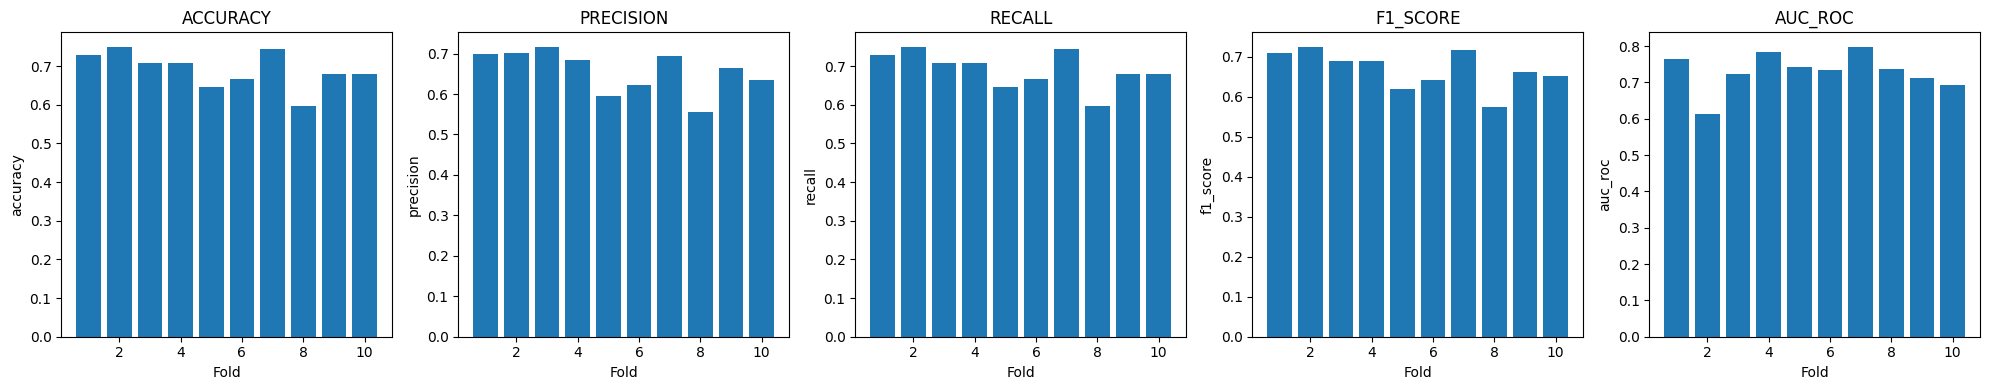

In [79]:

# %%
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))
metrics = ['accuracy','precision','recall','f1_score','auc_roc']
fig, axs = plt.subplots(1,len(metrics), figsize=(20,4))
for i,m in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[m]); axs[i].set_title(m.upper()); axs[i].set_xlabel('Fold'); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

# ## Step 7: Ensemble Averaging from 10 CV Models


In [80]:

# %%
ess_preds=[]
test_data=torch.load(os.path.join(base_path, f"{task}_test.pt"))
tl=DataLoader(test_data, batch_size=32)
for fold in range(10):
    model = GAT(in_channels=train_data[0].x.size(1), hidden_channels=hd,
                out_channels=num_classes, heads=1, dropout=dp).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval(); outs=[]
    with torch.no_grad():
        for b in tl: outs.append(model(b.to(device)).cpu())
    ess_preds.append(torch.cat(outs,0))
avg=torch.stack(ess_preds).mean(0)
f_pred=avg.argmax(1).numpy(); t_true=torch.cat([d.y for d in test_data]).numpy().astype(int)
pd.DataFrame({'True':t_true,'Pred':f_pred}).to_csv(os.path.join(results_dir,'ensemble_preds.csv'),index=False)
print('✅ Ensemble preds saved')

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/3519107944.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data=torch.load(os.path.join(base_path, 

✅ Ensemble preds saved


# ## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC


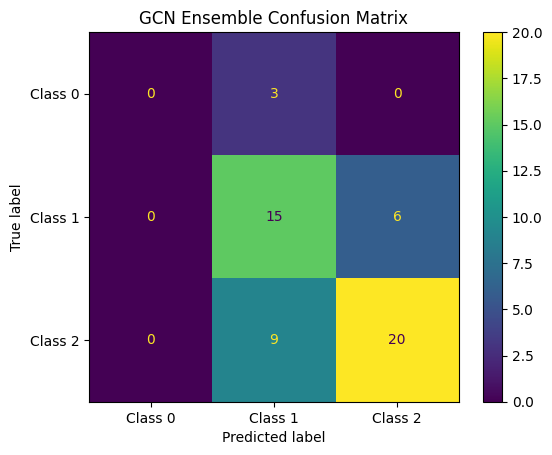

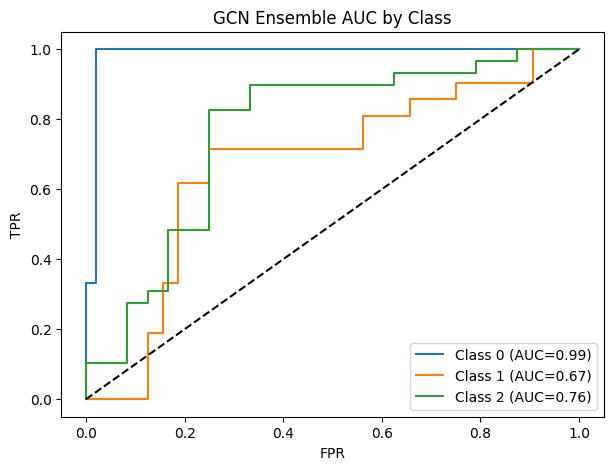

In [84]:
# Step 7: Ensemble Averaging on Test Set
from sklearn.metrics import auc

test_data = torch.load(
    os.path.join(base_path, f"{task}_test.pt"),
    weights_only=False
)
test_loader = DataLoader(test_data, batch_size=32)
all_preds = []

for fold in range(kfold):
    model = GAT(in_channels=test_data[0].x.size(1), hidden_channels=int(best_hidden_dim),
            out_channels=num_classes, heads=1, dropout=best_dropout).to(device)
    model.load_state_dict(
        torch.load(
            os.path.join(results_dir, f"fold{fold+1}_model.pt"),
            weights_only=False
        )
    )
    model.eval()
    preds_fold = []
    with torch.no_grad():
        for b in test_loader:
            preds_fold.append(model(b.to(device)).cpu())
    all_preds.append(torch.cat(preds_fold))

avg_preds = torch.stack(all_preds).mean(0)
y_true    = torch.cat([d.y for d in test_data]).numpy().astype(int)
y_pred    = avg_preds.argmax(dim=1).numpy()
pd.DataFrame({"True": y_true, "Pred": y_pred})\
  .to_csv(os.path.join(results_dir, "gcn_ensemble_preds.csv"), index=False)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    cm, display_labels=[f"Class {i}" for i in range(num_classes)]
)
disp.plot(); plt.title("GCN Ensemble Confusion Matrix"); plt.show()

# AUC by class
y_probs    = F.softmax(avg_preds, dim=1).numpy()
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("GCN Ensemble AUC by Class"); plt.legend(); plt.show()

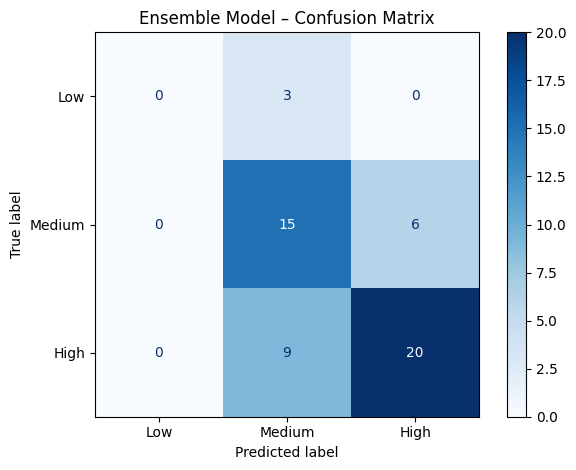

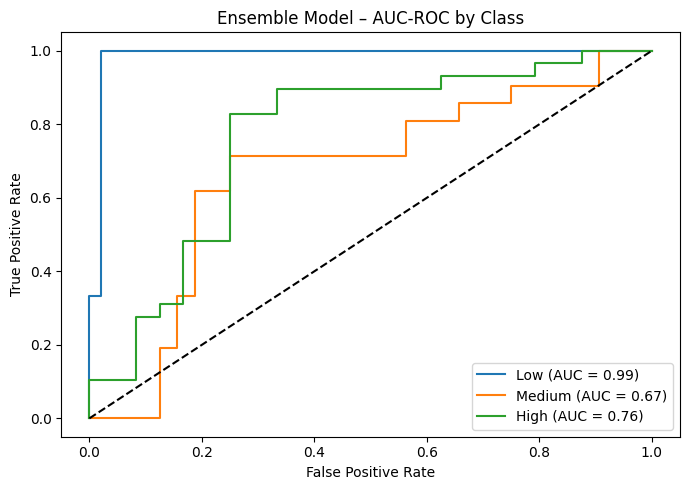

In [85]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Load ensemble predictions
ens_df = pd.read_csv(os.path.join(results_dir, 'ensemble_preds.csv'))
y_true_ens = ens_df['True'].values
y_pred_ens = ens_df['Pred'].values

# 1) Confusion matrix
cm = confusion_matrix(y_true_ens, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[class_names[i] for i in range(num_classes)])
disp.plot(cmap='Blues')
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

# 2) AUC‑ROC per class
# Need probability estimates – reload avg_output if available or recompute probabilities
# If you only have hard preds, rerun ensemble loop with model outputs saved as probs:
#     avg_probs = torch.stack(ensemble_prob_lists).mean(0).numpy()
# For now, assuming you have `avg_probs`:
avg_output = avg
y_probs = avg_output.softmax(dim=1).numpy()  # or your stored avg_probs
y_true_bin = label_binarize(y_true_ens, classes=np.arange(num_classes))

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model – AUC‑ROC by Class")
plt.legend()
plt.tight_layout()
plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/170317506.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data+=torch.load(os.path.join(base_path,f

Epoch 001 | Train Loss: 0.9140 | Val Loss: 0.8608 | Best Val Loss: 0.8608 | Patience: 0
Epoch 002 | Train Loss: 0.8476 | Val Loss: 0.8322 | Best Val Loss: 0.8322 | Patience: 0
Epoch 003 | Train Loss: 0.8170 | Val Loss: 0.8012 | Best Val Loss: 0.8012 | Patience: 0
Epoch 004 | Train Loss: 0.7870 | Val Loss: 0.7661 | Best Val Loss: 0.7661 | Patience: 0
Epoch 005 | Train Loss: 0.7630 | Val Loss: 0.7446 | Best Val Loss: 0.7446 | Patience: 0
Epoch 006 | Train Loss: 0.7450 | Val Loss: 0.7311 | Best Val Loss: 0.7311 | Patience: 0
Epoch 007 | Train Loss: 0.7362 | Val Loss: 0.7256 | Best Val Loss: 0.7256 | Patience: 0
Epoch 008 | Train Loss: 0.7280 | Val Loss: 0.7152 | Best Val Loss: 0.7152 | Patience: 0
Epoch 009 | Train Loss: 0.7207 | Val Loss: 0.7117 | Best Val Loss: 0.7117 | Patience: 0
Epoch 010 | Train Loss: 0.7163 | Val Loss: 0.7082 | Best Val Loss: 0.7082 | Patience: 0
Epoch 011 | Train Loss: 0.7110 | Val Loss: 0.7006 | Best Val Loss: 0.7006 | Patience: 0
Epoch 012 | Train Loss: 0.7078 |

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_33901/170317506.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join

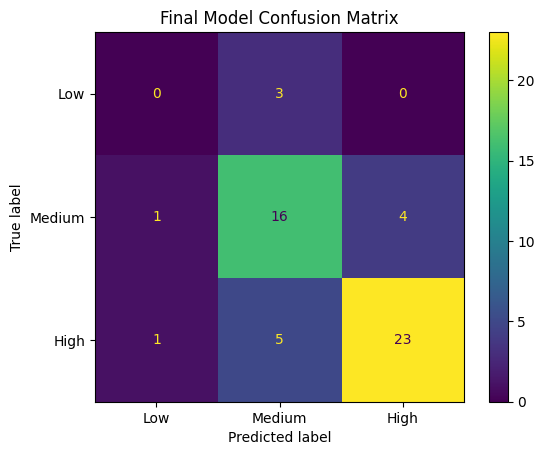

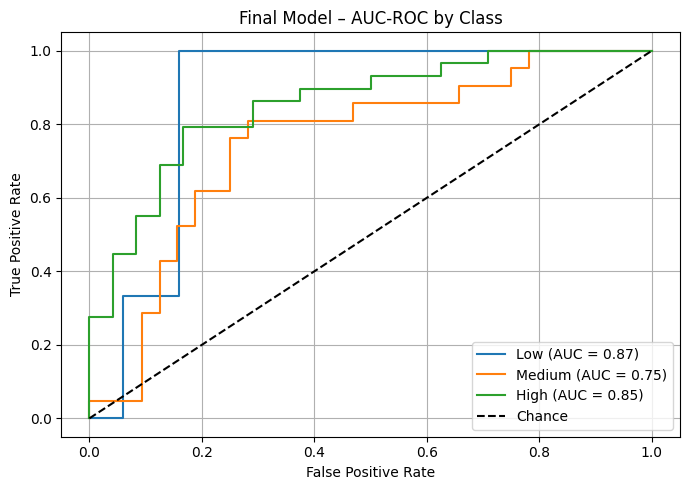

,Accuracy
ensemble,0.660377
final,0.735849


✅ Final metrics saved
✅ Final confusion matrix saved
✅ Final AUC-ROC saved
✅ Final predictions saved


In [86]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Merge train+val
all_data=[]
for fold in range(10):
    all_data+=torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data+=torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# small val
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=seed)
labels=[int(d.y.item()) for d in all_data]
train_idx,val_idx=next(sss.split(all_data,labels))
train_split=[all_data[i] for i in train_idx]; val_split=[all_data[i] for i in val_idx]
tr=DataLoader(train_split,batch_size=32,shuffle=True,worker_init_fn=seed_worker,generator=generator)
vl=DataLoader(val_split,batch_size=32)
model = GAT(in_channels=all_data[0].x.size(1), hidden_channels=int(best_hidden_dim),
                out_channels=num_classes, heads=1, dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,factor=0.5,verbose=True)
best_v=1e9;pat=0
for epoch in range(1,301):
    model.train();tot=0
    for b in tr: b=b.to(device);opt.zero_grad();o=model(b);l=F.cross_entropy(o,b.y.long());l.backward();opt.step();tot+=l.item()
    preds,labels=evaluate(model,vl);vloss=F.cross_entropy(preds,labels.long()).item();sched.step(vloss)
    if vloss<best_v:best_v=vloss;pat=0;torch.save(model.state_dict(),os.path.join(results_dir,'final_model.pt'))
    else: pat+=1
    if pat>=10:break
    print(f"Epoch {epoch:03d} | Train Loss: {tot/len(tr):.4f} | Val Loss: {vloss:.4f} | Best Val Loss: {best_v:.4f} | Patience: {pat}")

# test eval
model.load_state_dict(torch.load(os.path.join(results_dir,'final_model.pt')))
td=DataLoader(torch.load(os.path.join(base_path,f"{task}_test.pt")),batch_size=32)
preds,labels=evaluate(model,td);y_pred=preds.argmax(1).numpy();y_true=labels.numpy().astype(int)
# metrics
acc_f=accuracy_score(y_true,y_pred);prec,rec,f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
# confusion
cm=confusion_matrix(y_true,y_pred);disp=ConfusionMatrixDisplay(cm,display_labels=list(class_names.values()));disp.plot()
plt.title('Final Model Confusion Matrix');plt.show()
# final auc
 # Assume y_true is shape (n,) and preds is torch.Tensor of shape (n, num_classes)
probs     = F.softmax(preds, dim=1).cpu().numpy()     # (n, C)
y_true    = labels.numpy().astype(int)                 # (n,)
y_true_bin= label_binarize(y_true, classes=np.arange(num_classes))  # (n, C)

plt.figure(figsize=(7, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Model – AUC‑ROC by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

# Save final metrics
final_metrics = {
    'accuracy': acc_f,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'auc_roc': roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), probs, multi_class='ovr')
}
final_metrics_df = pd.DataFrame(final_metrics, index=[0])
final_metrics_df.to_csv(os.path.join(results_dir, 'final_metrics.csv'), index=False)
print("✅ Final metrics saved")
# Save final confusion matrix
cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())
cm_df.to_csv(os.path.join(results_dir, 'final_confusion_matrix.csv'))
print("✅ Final confusion matrix saved")
# Save final AUC-ROC
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_auc = auc(fpr, tpr)
roc_df.to_csv(os.path.join(results_dir, 'final_auc_roc.csv'), index=False)
print("✅ Final AUC-ROC saved")
# Save final predictions
preds_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
preds_df.to_csv(os.path.join(results_dir, 'final_predictions.csv'), index=False)
print("✅ Final predictions saved")


## Step 9: compare ensemble averaging to final model training results

In [87]:
# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

,Accuracy
ensemble,0.660377
final,0.735849
